This is the backup notebook to make sure if the calculation order does not affect the convergence.

# Stochastic approximation demo.

This notebook briefly shows how stochastic approximation works.

*Keisuke Fujii 7th Oct. 2016*

We show

+ Simple regression, that can be done also by usual Gaussian Process.      
+ Regression with non-Gaussian likelihood.

## Import several libraries including GPinv

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
# Import GPinv
import GPinv
# Import GPflow as comparison
import GPflow

# import graphical things
import seaborn as sns

sns.set_context('poster')
sns.set_style('ticks')
import matplotlib
fontprop = matplotlib.font_manager.FontProperties(fname="/usr/share/fonts/truetype/ttf-dejavu//")
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'DejaVu Sans'
matplotlib.rcParams['mathtext.it'] = 'DejaVu Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'DejaVu Sans:bold'

current_palette = sns.color_palette()

## Make random generator static

In [2]:
rng = np.random.RandomState(0)

# Simple regression

## Synthetic data

In [3]:
X = np.linspace(0,6,40).reshape(-1,1)
Y = np.sin(X) + rng.randn(40,1)*0.3

## GPflow.gpr.GPR

In [4]:
m_gpflow = GPflow.gpr.GPR(X, Y, GPflow.kernels.RBF(1))
rslt = m_gpflow.optimize()
rslt

      fun: 19.49947035345194
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -3.78487235e-06,   9.04234859e-07,  -2.35666935e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 16
      nit: 11
   status: 0
  success: True
        x: array([ 1.36444855, -0.21198308, -2.20949039])

In [5]:
X_new = np.linspace(-0.1,6.1,40).reshape(-1,1)
f_mu, f_var = m_gpflow.predict_f(X_new)

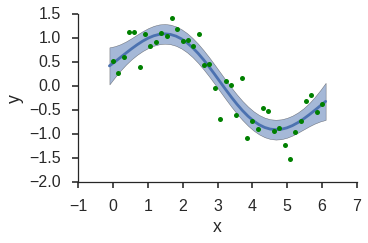

In [6]:
plt.figure(figsize=(5,3))
plt.fill_between(X_new.flatten(), (f_mu+2*np.sqrt(f_var)).flatten(), (f_mu-2*np.sqrt(f_var)).flatten(), alpha=0.5)
plt.plot(X_new, f_mu)
plt.plot(X, Y, 'go', ms = 5)
plt.xlabel('x')
plt.ylabel('y')

sns.despine()
plt.savefig('figs/simple_regression.pdf')

## GPinv.stvgp

In GPinv, we need custom likelihood, where at least the conditional likelihood of the data (**logp**) is specified.

The likelihood class should inherite GPinv.likelihood.Likelihood.

In [7]:
class GaussianLikelihood(GPinv.likelihoods.Likelihood):
    def __init__(self):
        GPinv.likelihoods.Likelihood.__init__(self)
        # variance parameter is assigned as GPinv.param.Param
        self.variance = GPinv.param.Param(1, GPinv.transforms.positive)
    
    def logp(self, F, Y):
        return GPinv.densities.gaussian(Y, F, self.variance)

### With Analytic KL approximation

In [8]:
# With stochastic KL
m_gpinv = GPinv.stvgp.StVGP(X, Y, GPinv.kernels.RBF(1, output_dim=1), likelihood=GaussianLikelihood(),
                            KL_analytic=True, 
                            num_samples=3)

In [9]:
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.05
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           20, 0.9)

In [10]:
trainer = tf.train.AdamOptimizer(learning_rate)

In [11]:
# This function visualizes the iteration.
from IPython import display

logf = []
def logger(x):
    if (logger.i % 5) == 0:
        obj = -m_gpinv._objective(x)[0]
        logf.append(obj)
        # display
        if (logger.i % 100) ==0:
            plt.clf()
            plt.plot(logf, '-ko', markersize=3, linewidth=1)
            plt.ylabel('ELBO')
            plt.xlabel('iteration')
            display.display(plt.gcf())
            display.clear_output(wait=True)
    logger.i+=1
logger.i = 1

Ellapsed Time is 7.817594528198242  (s)


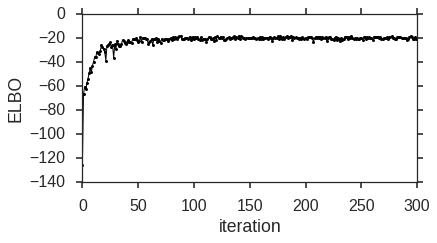

In [12]:
import time
# start time
logf = []
start_time = time.time()
plt.figure(figsize=(6,3))

# optimization by tf.train
_= m_gpinv.optimize(method=trainer, callback=logger, maxiter=1500, global_step = global_step)

display.clear_output(wait=True)
print('Ellapsed Time is', time.time()-start_time, ' (s)')

In [13]:
logf3 = np.array(logf)

In [14]:
# GPinv model also has predict_f method.
f_mu3, f_var3 = m_gpinv.predict_f(X_new)

### Model definition.

In [15]:
# With stochastic KL
m_gpinv = GPinv.stvgp.StVGP(X, Y, GPinv.kernels.RBF(1, output_dim=1), likelihood=GaussianLikelihood(),
                           num_samples = 3)

In [16]:
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.05
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           20, 0.9)

In [17]:
trainer = tf.train.AdamOptimizer(learning_rate)

Ellapsed Time is 8.407358169555664  (s)


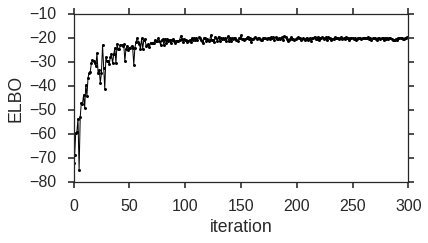

In [18]:
import time
# start time
logf = []
start_time = time.time()
plt.figure(figsize=(6,3))

# optimization by tf.train
_= m_gpinv.optimize(method=trainer, callback=logger, maxiter=1500, global_step = global_step)

display.clear_output(wait=True)
print('Ellapsed Time is', time.time()-start_time, ' (s)')

In [19]:
logf2 = np.array(logf)

In [20]:
# GPinv model also has predict_f method.
f_mu2, f_var2 = m_gpinv.predict_f(X_new)

### Compare results

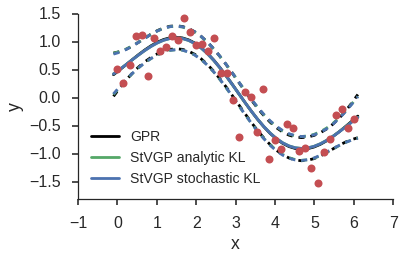

In [21]:
plt.figure(figsize=(6,4))

plt.plot(X_new, f_mu+2*np.sqrt(f_var), '--', color = 'k')
plt.plot(X_new, f_mu-2*np.sqrt(f_var), '--', color = 'k')
plt.plot(X_new, f_mu, '-k', label='GPR')

plt.plot(X_new, f_mu3+2*np.sqrt(f_var3), '--', color= current_palette[1])
plt.plot(X_new, f_mu3-2*np.sqrt(f_var3), '--', color= current_palette[1])
plt.plot(X_new, f_mu3, '-', label='StVGP analytic KL', color=current_palette[1])

plt.plot(X_new, f_mu2+2*np.sqrt(f_var2), '--', color= current_palette[0])
plt.plot(X_new, f_mu2-2*np.sqrt(f_var2), '--', color= current_palette[0])
plt.plot(X_new, f_mu2, '-', label='StVGP stochastic KL', color=current_palette[0])

plt.plot(X, Y, 'o', ms = 8, color=current_palette[2])

plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-1.8,1.5)

plt.legend(loc='best', fontsize=14)
sns.despine()
plt.tight_layout()
plt.savefig('figs/simple_regression.pdf')

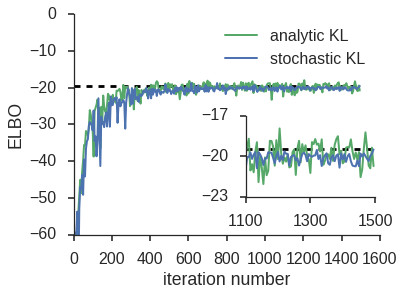

In [22]:
plt.figure(figsize=(6,4.5))
it = list(range(0,1500,5))
plt.plot([0,1500], [-rslt['fun'],-rslt['fun']], '--k')
plt.plot(it,logf3, label='analytic KL',   color=current_palette[1], lw=2)
plt.plot(it,logf2, label='stochastic KL', color=current_palette[0], lw=2)
plt.ylim(-60,0)
plt.xlabel('iteration number')
plt.ylabel('ELBO')
plt.legend(loc='upper right')
plt.tight_layout()

# this is an inset axes over the main axes
a = plt.axes([.6, .35, .3, .25])
plt.plot([1100,1500], [-rslt['fun'],-rslt['fun']], '--k')
plt.plot(it[220:300],logf3[220:300], color=current_palette[1], lw=2)
plt.plot(it[220:300],logf2[220:300], color=current_palette[0], lw=2)
plt.ylim(-23,-18)
plt.xticks([1100,1300,1500])
plt.yticks([-23,-20,-17])

sns.despine()
plt.savefig('figs/iteration_behavior.pdf')

In [23]:
print(np.std(logf2[220:300]))
print(np.std(logf3[220:300]))

0.348942805082
0.872107515159
